<a href="https://colab.research.google.com/github/ElingP/bcc_internship_2020_ds/blob/master/knn_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

===Original data===
Shape	:  (150, 5)


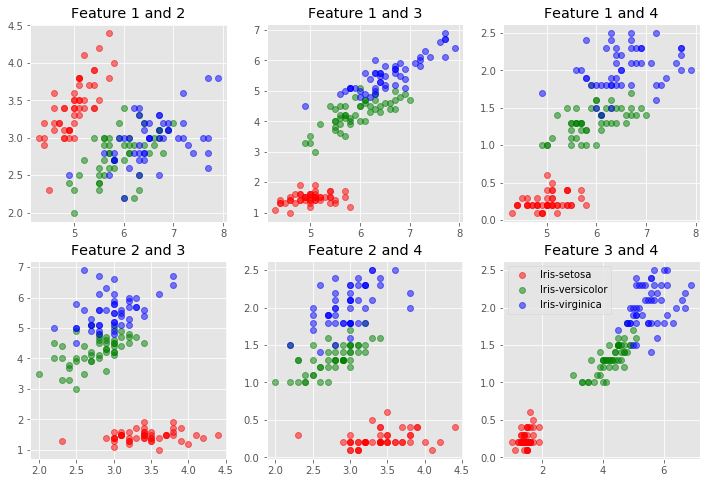


===Preprocessed data===
Shape	:  (150, 5)


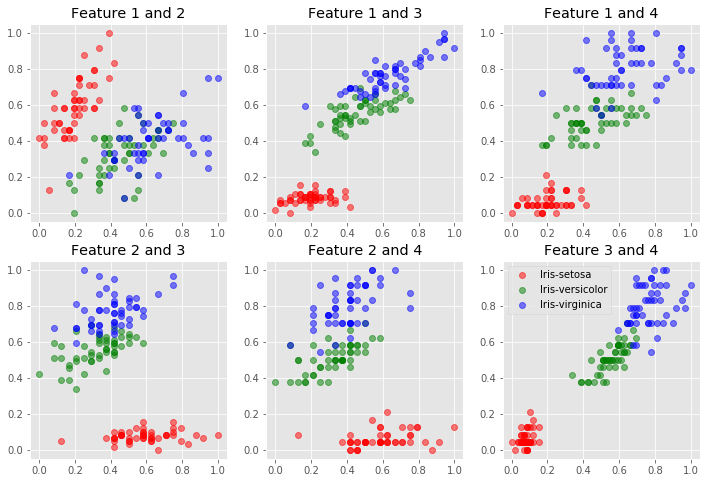


===Using our model===
Score (k = 11)	: 0.967


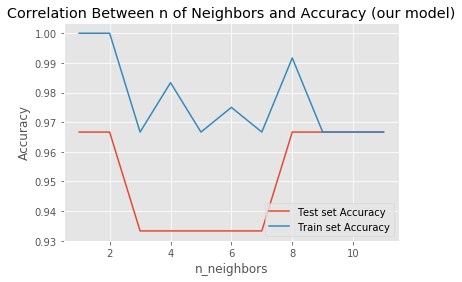


===Using scikit===
Score (k = 11)	: 0.967


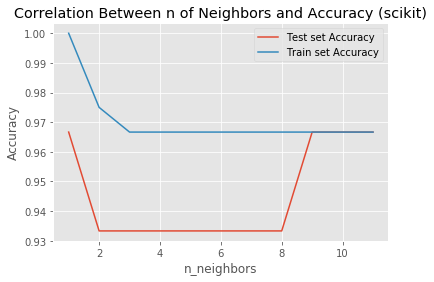

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from operator import itemgetter
plt.style.use('ggplot')

class KNearestNeighbors(object):

    X_train, y_train = None, None
    n_neighbors = 5
    
    def __init__(self, n_neighbors = 5):
        self.n_neighbors = n_neighbors

    # Calculate the Euclidean distance between two data
    def _euclidean_distance(self, data1, data2):
        distance = 0
        for i in range(len(data1)):
            distance += np.square(data1[i] - data2[i])
        return np.sqrt(distance)

    # Fit the train set into the object
    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    # Predict the target with its features
    def predict(self, X):
        y_pred = []

        for i in range(len(X)):
            
            distances = {}

            # Calculating Euclidean distance between each row of training data and test data
            for j in range(len(self.X_train)):
                dist = self._euclidean_distance(X[i], self.X_train[j])
                distances[j] = dist
            
            # Sorting them based on distance
            sorted_distances = sorted(distances.items(), key=itemgetter(1))
            
            neighbors = []

            # Finding top k neighbors
            for j in range(self.n_neighbors):
                neighbors.append(sorted_distances[j][0])

            class_votes = {}

            # Voting the most frequent class in the neighbors
            for j in range(len(neighbors)):
                response = self.y_train[neighbors[j]]

                if response in class_votes:
                    class_votes[response] += 1
                else:
                    class_votes[response] = 1

            sorted_votes = sorted(class_votes.items(), key=itemgetter(1), reverse=True)
            y_pred.append(sorted_votes[0][0])
        
        return np.array(y_pred)

    # Calculate the accuracy of the model
    def score(self, X, y):
        return np.mean(y == self.predict(X))

    # Iterate n_neighbors to find all scores and the best n_neighbors
    def cross_val_score(self, X_test, y_test, max_k = 10):
        neighbors = np.arange(1, max_k)
        train_accuracy = np.empty(len(neighbors))
        test_accuracy = np.empty(len(neighbors))
        best_k, best_accuracy = 0, 0
        
        # Loop over n_neighbors values
        for i in range(len(neighbors)):
            self.n_neighbors = neighbors[i]
            train_accuracy[i] = self.score(self.X_train, self.y_train)
            test_accuracy[i] = self.score(X_test, y_test)
            if (test_accuracy[i] >= best_accuracy):
                best_accuracy = test_accuracy[i]
                best_k = neighbors[i]
                
        return neighbors, train_accuracy, test_accuracy, best_k

    # Generate plot to visualize train and test data
    def generate_neighbors_plot(self, neighbors, train_accuracy, test_accuracy):
        plt.plot(neighbors, test_accuracy, label = 'Test set Accuracy') 
        plt.plot(neighbors, train_accuracy, label = 'Train set Accuracy') 
        plt.legend(loc = 'best') 
        plt.xlabel('n_neighbors') 
        plt.ylabel('Accuracy') 
        plt.title('Correlation Between n of Neighbors and Accuracy (our model)')
        plt.show()


class Utility(object):

    # Split a dataset into a train and test set
    def train_test_split(self, X, y, train_size = 0.75, random_state = None):
        np.random.seed(random_state)
        indices = np.random.permutation(X.shape[0])
        length = int(len(X) * train_size)
        training_idx, test_idx = indices[:length], indices[length:]
        X_train, X_test, y_train, y_test = X[training_idx,:], X[test_idx,:], y[training_idx], y[test_idx]
        return X_train, X_test, y_train, y_test
    
    # Impute missing values with either mean, median, or dropping the entire row
    def impute(self, data, missing_values = np.NaN, strategy = 'mean'):
        if (missing_values != np.NaN):
            data.iloc[:, :-1] = data.iloc[:, :-1].replace(missing_values, np.NaN)
        if (strategy == 'mean'):
            data.fillna(data.mean(), inplace = True)
        elif (strategy == 'median'):
            data.fillna(data.median(), inplace = True)
        else:
           data.dropna(inplace=True) 
        return data

    # Scale the data to 0-1
    def scale(self, X, high = 1.0, low = 0.0):
        mins = np.min(X, axis = 0)
        maxs = np.max(X, axis = 0)
        rng = maxs - mins
        return high - (((high - low) * (maxs - X)) / rng)

########################################################

print('===Original data===')

# Importing data
url = 'https://datahub.io/machine-learning/iris/r/iris.csv'
#url = 'https://datahub.io/machine-learning/ionosphere/r/ionosphere.csv' # data = data.drop(columns='a02')
#url = 'https://datahub.io/machine-learning/diabetes/r/diabetes.csv'
#url = 'https://datahub.io/machine-learning/sonar/r/sonar.csv'
#url = 'https://datahub.io/machine-learning/blood-transfusion-service-center/r/blood-transfusion-service-center.csv'
#url = 'https://datahub.io/machine-learning/glass/r/glass.csv'
#url = 'https://datahub.io/machine-learning/breast-w/r/breast-w.csv'
#url = 'https://datahub.io/machine-learning/banknote-authentication/r/banknote-authentication.csv'
#url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/wheat-seeds.csv' # header = None
#url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv' # sep = ';'
#url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv' # sep = ';'

data = pd.read_csv(url)

print(data.head(20))
print('Shape\t: ', data.shape)

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

f1 = X[:,0]
f2 = X[:,1]
f3 = X[:,2]
f4 = X[:,3]

colors = ['r','g','b']
f,ax = plt.subplots(2,3,figsize=(12,8))
ax[0][0].set_title('Feature 1 and 2')
ax[0][1].set_title('Feature 1 and 3')
ax[0][2].set_title('Feature 1 and 4')
ax[1][0].set_title('Feature 2 and 3')
ax[1][1].set_title('Feature 2 and 4')
ax[1][2].set_title('Feature 3 and 4')

for i, target in enumerate(np.unique(y)):
    ax[0][0].plot(f1[y==target],f2[y==target],'o',color=colors[i], alpha=0.5, label=target)
    ax[0][1].plot(f1[y==target],f3[y==target],'o',color=colors[i], alpha=0.5, label=target)
    ax[0][2].plot(f1[y==target],f4[y==target],'o',color=colors[i], alpha=0.5, label=target)
    ax[1][0].plot(f2[y==target],f3[y==target],'o',color=colors[i], alpha=0.5, label=target)
    ax[1][1].plot(f2[y==target],f4[y==target],'o',color=colors[i], alpha=0.5, label=target)
    ax[1][2].plot(f3[y==target],f4[y==target],'o',color=colors[i], alpha=0.5, label=target)
    ax[1][2].legend(loc='best')

plt.show()

########################################################

print('\n===Preprocessed data===')

# Preproceessing data by removing or replacing missing value
util = Utility()
data = util.impute(data, missing_values = 0, strategy = 'mean')

# Normalizing the features data
data.iloc[:, :-1] = util.scale(data.iloc[:, :-1])

print('Shape\t: ', data.shape)

# Splitting data into features (X) and target (y)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

f1 = X[:,0]
f2 = X[:,1]
f3 = X[:,2]
f4 = X[:,3]

colors = ['r','g','b']
f,ax = plt.subplots(2,3,figsize=(12,8))
ax[0][0].set_title('Feature 1 and 2')
ax[0][1].set_title('Feature 1 and 3')
ax[0][2].set_title('Feature 1 and 4')
ax[1][0].set_title('Feature 2 and 3')
ax[1][1].set_title('Feature 2 and 4')
ax[1][2].set_title('Feature 3 and 4')

for i, target in enumerate(np.unique(y)):
    ax[0][0].plot(f1[y==target],f2[y==target],'o',color=colors[i], alpha=0.5, label=target)
    ax[0][1].plot(f1[y==target],f3[y==target],'o',color=colors[i], alpha=0.5, label=target)
    ax[0][2].plot(f1[y==target],f4[y==target],'o',color=colors[i], alpha=0.5, label=target)
    ax[1][0].plot(f2[y==target],f3[y==target],'o',color=colors[i], alpha=0.5, label=target)
    ax[1][1].plot(f2[y==target],f4[y==target],'o',color=colors[i], alpha=0.5, label=target)
    ax[1][2].plot(f3[y==target],f4[y==target],'o',color=colors[i], alpha=0.5, label=target)
    ax[1][2].legend(loc='best')

plt.show()

# Splitting the data into 80% train and 20% test set with a random seed of 42
X_train, X_test, y_train, y_test = util.train_test_split(X, y, train_size = 0.8, random_state = 42)

########################################################

print('\n===Using our model===')

# Fitting and printing the score of KNN
knn = KNearestNeighbors()
knn.fit(X_train, y_train)

# Getting the accuracy score for k in 0 < k < sqrt(num of rows)
neighbors, train_accuracy, test_accuracy, best_k = knn.cross_val_score(X_test, y_test, max_k = int(np.sqrt(X.shape[0])))

# Printing the score of KNN with best n_neighbors
knn.n_neighbors = best_k
print('Score (k = %d)\t: %.3f'% (knn.n_neighbors, knn.score(X_test, y_test)))

# Generating plot to view where is the best k for accuracy with x axis being "n_neighbors"
knn.generate_neighbors_plot(neighbors, train_accuracy, test_accuracy)


########################################################

print('\n===Using scikit===')

from sklearn.neighbors import KNeighborsClassifier  
  
neighbors = np.arange(1, int(np.sqrt(X.shape[0]))) 
train_accuracy = np.empty(len(neighbors)) 
test_accuracy = np.empty(len(neighbors))
best_k, best_accuracy = 0, 0
  
# Loop over K values 
for i, k in enumerate(neighbors): 
    knn = KNeighborsClassifier(n_neighbors=k) 
    knn.fit(X_train, y_train) 
      
    # Compute traning and test data accuracy 
    train_accuracy[i] = knn.score(X_train, y_train) 
    test_accuracy[i] = knn.score(X_test, y_test)
    if (test_accuracy[i] >= best_accuracy):
        best_accuracy = test_accuracy[i]
        best_k = neighbors[i]

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
print('Score (k = %d)\t: %.3f'% (best_k, knn.score(X_test, y_test)))

# Generate plot 
plt.plot(neighbors, test_accuracy, label = 'Test set Accuracy') 
plt.plot(neighbors, train_accuracy, label = 'Train set Accuracy') 
  
plt.legend(loc='best') 
plt.xlabel('n_neighbors') 
plt.ylabel('Accuracy')
plt.title('Correlation Between n of Neighbors and Accuracy (scikit)')
plt.show() 